<a href="https://colab.research.google.com/github/sohom21d/Multimodal-Brain-Tumour-Segmentation/blob/master/brats_update1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check hardware

In [73]:
! lscpu |grep 'Model name'
! lscpu |grep 'Core(s) per socket'
! nvidia-smi -L

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Core(s) per socket:  1
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Prevent Idle Timeout
Ctrl+ Shift + i to open inspector view . Then goto console and paste this code.
```
function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click() 
 }
 setInterval(ClickConnect,60000)
```



In [2]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [3]:
! unzip -q '/content/drive/My Drive/Datasets/BRATS2020/MICCAI_BraTS2020_TrainingData.zip'

## Import

In [1]:
import os
import glob
import shutil

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, Conv3DTranspose, concatenate, BatchNormalization

## Data pipeline

In [38]:
folders = sorted(glob.glob('/content/MICCAI_BraTS2020_TrainingData/*'))
print('Number of samples: ', len(folders))

Number of samples:  371


In [39]:
def read(file_path):
  img = nib.load(file_path).get_fdata()
  return img

In [40]:
def get_img(folder):
  sample = folder.split('/')[-1]
  t1 = read(f'{folder}/{sample}_t1.nii.gz')
  t1ce = read(f'{folder}/{sample}_t1ce.nii.gz')
  t2 = read(f'{folder}/{sample}_t2.nii.gz')
  flair = read(f'{folder}/{sample}_flair.nii.gz')
  img = np.stack([t1, t1ce, t2, flair], axis=-1)
  return img

In [41]:
def get_msk(folder):
  sample = folder.split('/')[-1]
  msk = read(f'{folder}/{sample}_seg.nii.gz')
  msk[np.where(msk==4)] = 3
  msk = tf.keras.utils.to_categorical(msk, num_classes=4)
  return msk

In [42]:
img = get_img(folders[1])
msk = get_msk(folders[1])

print(img.shape)
print(msk.shape)

(240, 240, 155, 4)
(240, 240, 155, 4)


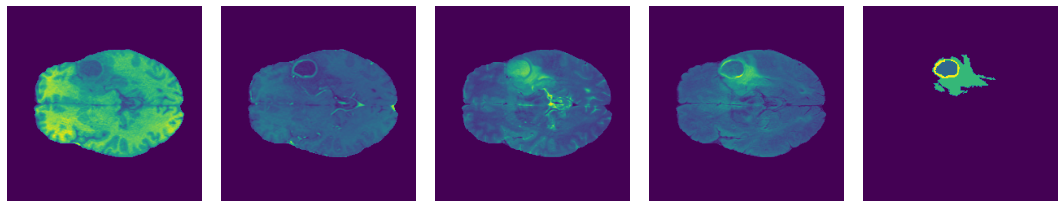

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
for i in range(4):
  axes[i].imshow(img[:,:,c, i])
  axes[i].axis('off')
axes[4].imshow(np.argmax(msk, axis=-1)[:,:,c])
axes[4].axis('off')
plt.tight_layout()
plt.show()

## Metrics

In [131]:
def mean_iou(y_true, y_pred):
  epsilon = 1e-6
  axes = (1,2,3) # Skip the batch axis and channel axis
  y_true = tf.cast(y_true > 0.5, tf.float32)
  y_pred = tf.cast(y_pred > 0.5, tf.float32)
  numerator = tf.math.reduce_sum(y_true * y_pred, axes)
  denominator = tf.math.reduce_sum(y_true + y_pred, axes) - numerator
  iou = tf.math.reduce_mean((numerator + epsilon) / (denominator + epsilon))
  return iou

def dice_score(y_true, y_pred):
  epsilon = 1e-6
  axes = (1,2,3) # Skip the batch axis and channel axis
  y_true = tf.cast(y_true > 0.5, tf.float32)
  y_pred = tf.cast(y_pred > 0.5, tf.float32)
  numerator = 2. * tf.math.reduce_sum(y_true * y_pred, axes)
  denominator = tf.math.reduce_sum(np.square(y_true) + np.square(y_pred), axes)
  score = tf.math.reduce_mean((numerator + epsilon) / (denominator + epsilon))
  return score

## Loss Function

In [133]:
def soft_dice_loss(y_true, y_pred):
  epsilon = 1e-6
  axes = (1,2,3) # Skip the batch axis and channel axis
  numerator = 2. * tf.math.reduce_sum(y_true * y_pred, axes)
  denominator = tf.math.reduce_sum(np.square(y_true) + np.square(y_pred), axes)
  loss = 1.0 - tf.math.reduce_mean((numerator + epsilon) / (denominator + epsilon))
  return loss

## Model

In [137]:
def Conv3DNorm2X(input_tensor, filters):
    '''
    conv3d->batchnorm->conv3d->batchnorm
    '''
    output_tensor = Conv3D(filters, kernel_size=(3,3,3), padding='same', activation='relu', kernel_initializer='he_normal')(input_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    output_tensor = Conv3D(filters, kernel_size=(3,3,3), padding='same', activation='relu', kernel_initializer='he_normal')(output_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    return output_tensor

In [141]:
def unet3d(input_shape=(128,128,16,1), n_classes=1, start_filters=32):

    '''
    input_shape = (H, W, D, C)
    n_classes = number of classes (ouput channels)
    start_filters = starting encoder layer filters
    '''

    f = [start_filters, start_filters*2, start_filters*3, start_filters*4, start_filters*5]

    inputs = Input(input_shape)

    c1 = Conv3DNorm2X(inputs, f[0])
    p1 = MaxPool3D()(c1)

    c2 = Conv3DNorm2X(p1, f[1])
    p2 = MaxPool3D()(c2)

    c3 = Conv3DNorm2X(p2, f[2])
    p3 = MaxPool3D()(c3)

    c4 = Conv3DNorm2X(p3, f[3])
    p4 = MaxPool3D()(c4)

    c5 = Conv3DNorm2X(p4, f[4])

    u6 = Conv3DTranspose(f[3], kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3DNorm2X(u6, f[3])

    u7 = Conv3DTranspose(f[2], kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3DNorm2X(u7, f[2])

    u8 = Conv3DTranspose(f[1], kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3DNorm2X(u8, f[1])

    u9 = Conv3DTranspose(f[0], kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3DNorm2X(u9, f[0])

    outputs = Conv3D(n_classes, kernel_size=(1,1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [147]:
model = unet3d(input_shape=(128,128,16,1), n_classes=4, start_filters=32)

In [148]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=soft_dice_loss,
              metrics=[mean_iou, dice_score])

## Model Training

In [142]:
weights_save_path = '/content/weights'

if not os.path.exists(weights_save_path):
    os.mkdir(weights_save_path)

cpk_path = weights_save_path+'/weights_{epoch:03d}-{val_mean_iou:.4f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  filepath=cpk_path,
  monitor='val_iou',
  mode='max',
  verbose=1,
  save_best_only=True,
  save_weights_only=True,
  save_freq='epoch'
  )

reducelr = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.1,
  patience=5,
  verbose=1)

callbacks = [checkpoint, reducelr]

In [ ]:
'''
start_epoch = 0
final_epoch = 2
train_steps = len(train_img_files)//BATCH_SIZE

history = model.fit(
  x=train_dataset,
  steps_per_epoch=train_steps,
  initial_epoch=start_epoch,
  epochs=final_epoch,
  validation_data=valid_dataset,
  callbacks=callbacks,
  verbose=1
)
'''